# Create ratemaps 
Jump to the bottom of the notebook for the generation of rate maps

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import expipe
import pathlib
import numpy as np
import place_stimulation as ps
import neo
import quantities as pq
import matplotlib.pylab as plt

par = {'speed_filter': 0.3, # m/s
       'pos_fs': 60 ,
       'f_cut': 1,
       'spat_binsize': 0.02 ,
       'spat_smoothing': 0.025,
       'grid_stepsize': 0.1 ,
       'box_xlen': 1 ,
       'box_ylen': 1 ,
       'spike_size': 10,
       'field_max_wall_extent':0.1,
       'field_min_bins':12
}

# Load project in python using expipe

In [3]:
project_path = "expipe-project-path-here"
project = expipe.get_project(project_path)
actions = project.actions

In [4]:
actions

In [5]:
action = actions['1806-031218-3']

In [7]:
data_path = ps.get_data_path(action)

/home/alessiob/Documents/Codes/expipe/projects/testing
actions/1806-031218-3/data/main.exdir


In [8]:
# For Intan recording and Open Ephys tracking clip spiketrains, epochs (stimulation triggers) using:
# - digital input evet used for sync in intan (available in main.exdir/epochs/intan-events/digital-in-0 (or 1))
# and Open Ephys tracking using:
# - sync event form open-ephys (available in main.exdir/epochs/open-ephys-events/sync_...)

In [18]:
sptr = ps.load_spiketrains(data_path, channel_idx=3, remove_label='noise')

5
1


In [49]:
# select red here
x, y, t, speed = ps.load_tracking(data_path, par, select_tracking=1)

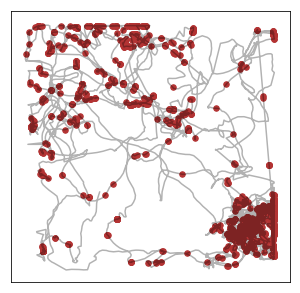

In [50]:
ps.plot_path(x, y, t, sptr[0])

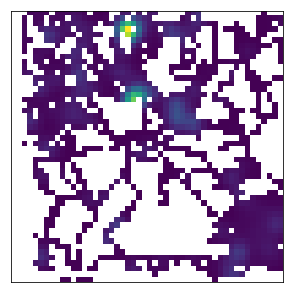

In [51]:
ps.plot_rate_map(x, y, t, sptr[0])

In [ ]:
epochs = ps.load_epochs(data_path)

In [ ]:
# extract relevalt epoch e.g.
epc = epochs[0]

In [ ]:
ps.plot_psth(sptr[0], epc, bin_size=0.1 * pq.s)

In [ ]:
plt.plot(x)